In [3]:
import numpy as np
import pandas as pd
import openml
import pickle
import os
import sys
from meta_model.utils import ndcg_sim, ndcg, custom_sim, load_meta_dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

BENCHMARK_RESULTS_DIR = "meta_dataset_creation/data/benchmark_results/"
META_FEATURES_FILE = "meta_dataset_creation/data/meta_features/original/meta_features.csv"

dataset_statistics = ["n_instances", "n_features",
                        "dim", "num_on_cat", "n_num_att", "n_cat_att"]

attributes_statistics = [
    f"{p}_{name}" for p in ["min", "q1", "mean", "q3", "max"] for name in [
        "means_num_att", "std_num_att",
        "card_cat_att", "entropy_cat_att",
        "covariance",
    ]
]

baseline_pairs = {
    "haverage": "manhattan_hamming",
    "fasterpam": "euclidean_hamming",
    "kprototypes": "sqeuclidean_hamming",
}

names = {
    "haverage": "H-AVG",
    "fasterpam": "K-MED",
    # "spectral": "Spectral",
    "kprototypes": "K-PROTO",
}

In [4]:
import openml

openml_df = openml.datasets.list_datasets(output_format="dataframe")
df = openml_df[openml_df.NumberOfNumericFeatures >= 1]
df = df[df.NumberOfSymbolicFeatures >= 2]
df = df[df.NumberOfInstances >= 30]
df = df[df.NumberOfMissingValues <= 0.1 *
        df.NumberOfFeatures*df.NumberOfInstances]
df = df[df.NumberOfClasses >= 2]
dict_ = {"NumberOfFeatures":"Features", "NumberOfInstances": "Instances", "NumberOfNumericFeatures":"Num. Features", "NumberOfSymbolicFeatures": "Cat. Features", "NumberOfClasses": "Classes"}
df= df.rename(columns=dict_)

dataset_list = [int(filename.split('.')[0])
                           for filename in os.listdir("meta_dataset_creation/data/benchmark_results/kprototypes/original/scores/")]

df[df.did.isin(dataset_list)][dict_.values()].describe().astype(int)

,Features,Instances,Num. Features,Cat. Features,Classes
count,182,182,182,182,182
mean,34,124755,14,20,3
std,119,661500,31,115,4
min,3,34,1,2,2
25%,9,205,3,3,2
50%,16,690,7,6,2
75%,30,5024,14,14,3
max,1559,5100000,294,1556,48


In [5]:
train_res_dir = "meta_model/data/training_red/"
train_res = {}
for name in os.listdir(train_res_dir):
    algorithm, eval_metric = name.split('.')[0].split('_')
    print(algorithm, eval_metric)
    if algorithm not in train_res:
        train_res[algorithm] = {}
    filename = os.path.join(train_res_dir, name)
    with open(filename, "rb") as f:
        train_res[algorithm][eval_metric] = pickle.load(f)
        mixed_meta_df, benchmark_results = train_res[algorithm][eval_metric]["meta_dataset"]
        Y = benchmark_results.to_numpy()
        if eval_metric in ["acc", "purity"]:
            Yn = np.array([y/max(y) for y in Y])
            # Yn[Yn > 0] **= 4
            Yn[Yn <= 0] = -1
        elif eval_metric == "ari":
            Yn = np.array([(y+0.5)/max(y+0.5) for y in Y])
            Yn[Yn <= 0] = -1
        else:
            Yn = np.array([(y+1)/max(y+1) for y in Y])
            Yn[Yn <= 0] = -1
        X = mixed_meta_df.to_numpy()
        sc = StandardScaler().fit(X)
        X = sc.transform(X)
        X2 = X[:, [i for i in range(X.shape[1]) if mixed_meta_df.columns.values[i] in dataset_statistics+attributes_statistics]]
        train_res[algorithm][eval_metric]["Y"] = Y
        train_res[algorithm][eval_metric]["Yn"] = Yn
        train_res[algorithm][eval_metric]["X"] = X
        train_res[algorithm][eval_metric]["X2"] = X2
        # print(train_res[algorithm][eval_metric]["train_results"]["AMF-FS-KNN"])
        selected_feats = train_res[algorithm][eval_metric]["train_results"]["AMF-FS-KNN"]["selected_features"]
        selected_feats2 = train_res[algorithm][eval_metric]["train_results"]["LMF-FS-KNN"]["selected_features"]
        train_res[algorithm][eval_metric]["selected_features"] = mixed_meta_df.columns.to_numpy()[selected_feats]
        train_res[algorithm][eval_metric]["selected_features2"] = np.array([col for col in mixed_meta_df.columns if col in dataset_statistics+attributes_statistics])[selected_feats2]

kprototypes acc
kprototypes sil
kprototypes ari
kprototypes purity
fasterpam acc
fasterpam sil
fasterpam ari
fasterpam purity
haverage acc
haverage sil
haverage ari
haverage purity


In [6]:
# def load_data(algorithm, eval_metric):
#     scores_dir = os.path.join(BENCHMARK_RESULTS_DIR, algorithm, "original/scores")
#     mixed_meta_df, benchmark_results = load_meta_dataset(META_FEATURES_FILE, scores_dir, algorithm, eval_metric)

#     index = benchmark_results.index
#     Y = benchmark_results[index.isin(mixed_meta_df.index)].to_numpy()
#     if eval_metric in ["acc", "purity"]:
#         Yn = np.array([y/max(y) for y in Y])
#         # Yn[Yn > 0] **= 4
#         Yn[Yn <= 0] = -1
#     elif eval_metric == "ari":
#         Yn = np.array([(y+0.5)/max(y+0.5) for y in Y])
#         Yn[Yn <= 0] = -1
#     else:
#         Yn = np.array([(y+1)/max(y+1) for y in Y])
#         Yn[Yn <= 0] = -1
#     X = mixed_meta_df.loc[[i for i in index if i in mixed_meta_df.index]].to_numpy()
#     sc = StandardScaler().fit(X)
#     X = sc.transform(X)
#     X2 = X[:, [i for i in range(X.shape[1]) if mixed_meta_df.columns.values[i] in dataset_statistics+attributes_statistics]]
#     return X, X2, Y, Yn, mixed_meta_df.columns.values, [col for col in mixed_meta_df.columns.values if col in dataset_statistics+attributes_statistics], benchmark_results.columns.values

In [7]:
results = {}
for algorithm in train_res:
    results[algorithm] = {}
    for eval_metric in train_res[algorithm]:
        print(algorithm, eval_metric)
        results[algorithm][eval_metric] = {}
        Y = train_res[algorithm][eval_metric]["Y"]
        Yn = train_res[algorithm][eval_metric]["Yn"]

        ndcg_ranks = [1, 3, 5, 10, 15, 20]
        n_bests = [1, 3, 5, 10]
        ndcg_scores = {
            model_name: {p: np.zeros(X.shape[0]) for p in ndcg_ranks}
            for model_name in train_res[algorithm][eval_metric]["train_results"]
        } #| {'ensemble': {p: np.zeros(meta_X.shape[0]) for p in ndcg_ranks}}

        lb_scores = np.zeros(X.shape[0])
        rb_scores = {k: np.zeros(X.shape[0]) for k in n_bests}
        mb_scores = np.zeros(X.shape[0])
        model_scores = {
            model_name: {k: np.zeros(X.shape[0]) for k in n_bests}
            for model_name in train_res[algorithm][eval_metric]["train_results"]
        } #| {'ensemble': {k: np.zeros(len(test_index)) for k in n_bests}}

        for name, obj in train_res[algorithm][eval_metric]["train_results"].items():
            Y_pred = obj["pred"]
            for p in ndcg_ranks:
                ndcg_scores[name][p] = ndcg(Yn, Y_pred, p=p)
            for k in n_bests:
                model_scores[name][k] = np.array(
                    [max(y[y > -1][np.argsort(-Y_pred[i][y > -1])[:k]]) for i, y in enumerate(Y)])
        for k in n_bests:
            rb_scores[k] = np.array(
                [max(np.random.choice(y[y > -1], k)) for y in Y])
    
        benchmark_results = train_res[algorithm][eval_metric]["meta_dataset"][1]
        similarity_pairs = benchmark_results.columns.values
        sim_pairs_index = dict(zip(similarity_pairs, range(len(similarity_pairs))))
        lb_scores = Y[:, sim_pairs_index[baseline_pairs[algorithm]]]
        mb_scores = np.max(Y, axis=1)

        results[algorithm][eval_metric]["scores"] = model_scores
        results[algorithm][eval_metric]["scores"]["LB"] = {1: lb_scores}
        results[algorithm][eval_metric]["scores"]["RB"] = rb_scores
        results[algorithm][eval_metric]["scores"]["Oracle"] = {1: mb_scores}
        results[algorithm][eval_metric]["ndcg"] = ndcg_scores

kprototypes acc
kprototypes sil


kprototypes ari
kprototypes purity
fasterpam acc
fasterpam sil
fasterpam ari
fasterpam purity
haverage acc
haverage sil
haverage ari
haverage purity


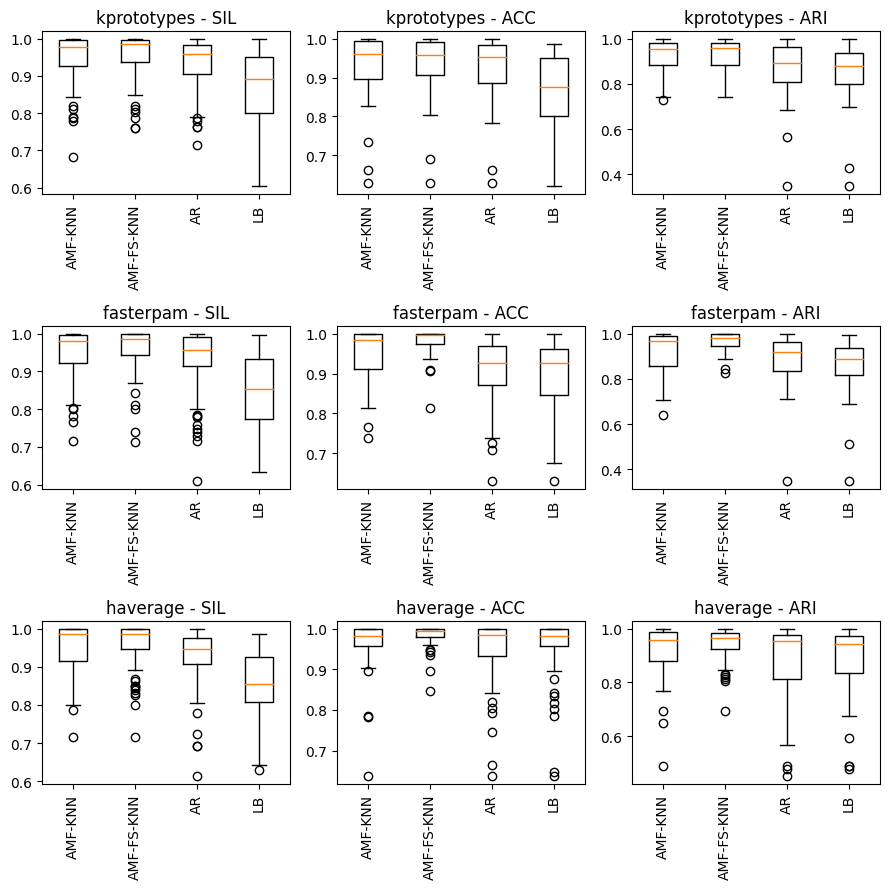

In [8]:
rows, cols = 3, 3
model_names = ["AMF-KNN", "AMF-FS-KNN", "AR", "LB"]
plt.figure(figsize=(cols*3, rows*3))
i = 1
for algorithm in results:
    for eval_metric in ["sil", "acc", "ari"]:
        y = {}
        best_scores = results[algorithm][eval_metric]["scores"]["Oracle"][1]
        lb_scores = results[algorithm][eval_metric]["scores"]["LB"][1]
        for name in model_names:
            l = results[algorithm][eval_metric]["scores"][name][1]
            if eval_metric in ["sil"]:
                y[name] = (l+1)/(best_scores+1)
            elif eval_metric in ["acc"]:
                y[name] = (l)/(best_scores)
            elif eval_metric in ["ari"]:
                y[name] = (l+0.5)/(best_scores+0.5)
            # y[name] = (l-lb_scores)
        plt.subplot(rows, cols, i)
        # print(list(y.values())[0])
        plt.boxplot(y.values(), labels=y.keys())
        plt.title(f"{algorithm} - {eval_metric.upper()}")
        plt.xticks(rotation="vertical")
        i += 1
plt.tight_layout()
plt.show()

In [9]:
model_names = ["AR", "AMF-FS-KNN"]
for eval_metric in ["sil", "acc", "ari"]:
    obj = {}
    print(f"top-k {eval_metric} for different values of k")
    for algorithm in results:
        Y = train_res[algorithm][eval_metric]["Y"]
        best_scores = results[algorithm][eval_metric]["scores"]["Oracle"][1]
        for name in ["LB", "RB"]:
            if name not in obj:
                obj[name] = {}
            l = results[algorithm][eval_metric]["scores"][name][1]
            if eval_metric in ["sil"]:
                y[name] = (l+1)/(best_scores+1)
            elif eval_metric in ["acc"]:
                y[name] = (l)/(best_scores)
            elif eval_metric in ["ari"]:
                y[name] = (l+0.5)/(best_scores+0.5)
            obj[name][f"({algorithm[0]}) top-01"] = \
                f"{np.format_float_positional(np.mean(l), 3)}±{np.format_float_positional(np.std(l), 2)}"

        for model_name in model_names:
            if model_name not in obj:
                obj[model_name] = {}
            for k in [1, 10]:
                l = results[algorithm][eval_metric]["scores"][model_name][k]
                if eval_metric in ["sil"]:
                    y[name] = (l+1)/(best_scores+1)
                elif eval_metric in ["acc"]:
                    y[name] = (l)/(best_scores)
                elif eval_metric in ["ari"]:
                    y[name] = (l+0.5)/(best_scores+0.5)
                obj[model_name][f"({algorithm[0]}) top-{k:02d}"] = \
                    f"{np.format_float_positional(np.mean(l), 3)}±{np.format_float_positional(np.std(l), 2)}"

            # for p in [5, 10]:
            #     l = results[algorithm][eval_metric]["ndcg"][model_name][p]
            #     obj[model_name][f"({algorithm[0]}) ndcg@{k:02d}"] = \
            #         f"{np.format_float_positional(np.mean(l), 3)}±{np.format_float_positional(np.std(l), 2)}"

    print(pd.DataFrame.from_dict(obj, orient="index")[sorted(obj["AR"])])
    print()

top-k sil for different values of k
            (f) top-01  (f) top-10  (h) top-01  (h) top-10  (k) top-01  \
LB          0.396±0.23         NaN   0.500±0.2         NaN  0.433±0.22   
RB          0.403±0.21         NaN  0.516±0.20         NaN  0.418±0.20   
AR          0.541±0.23  0.596±0.21  0.620±0.19  0.695±0.19  0.532±0.19   
AMF-FS-KNN  0.589±0.21  0.622±0.20  0.682±0.19  0.715±0.18  0.570±0.21   

            (k) top-10  
LB                 NaN  
RB                 NaN  
AR          0.589±0.21  
AMF-FS-KNN  0.601±0.20  

top-k acc for different values of k
            (f) top-01  (f) top-10  (h) top-01  (h) top-10  (k) top-01  \
LB           0.732±0.1         NaN   0.786±0.1         NaN  0.702±0.11   
RB          0.730±0.10         NaN  0.773±0.11         NaN  0.700±0.11   
AR          0.741±0.10  0.797±0.08  0.784±0.11  0.819±0.09   0.752±0.1   
AMF-FS-KNN  0.806±0.09  0.812±0.09  0.816±0.09  0.821±0.09  0.764±0.09   

            (k) top-10  
LB                 NaN  
RB        

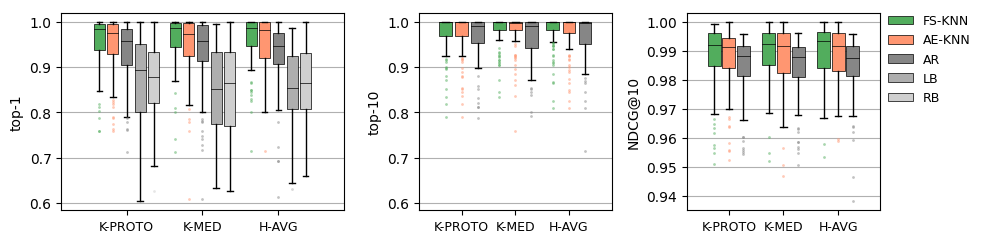

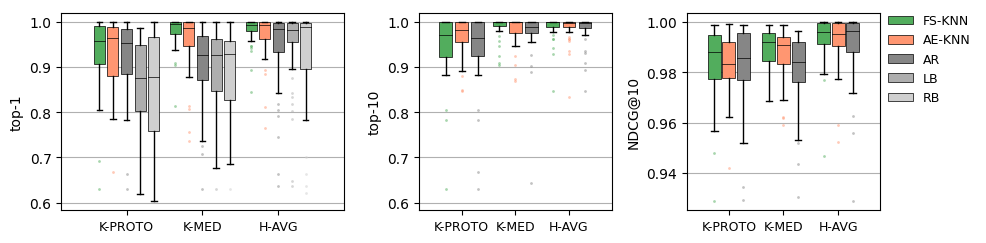

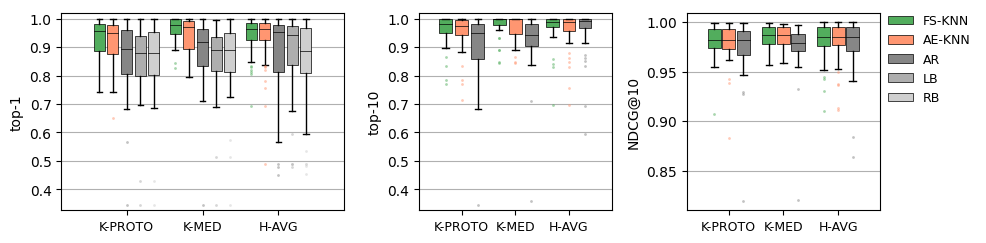

In [10]:
def show_scores(results, savedir=None):
    colors = {
        "AMF-FS-KNN": "#52AD5D",
        "AMF-AE-KNN": "#FF9671",
        "AR": "#868686",
        "LB": "#AEAEAE",
        "RB": "#CFCFCF",
    }
    labels = {k: k for k in colors}
    labels["AMF-FS-KNN"] = "FS-KNN"
    labels["AMF-AE-KNN"] = "AE-KNN"

    model_names = ["AMF-FS-KNN", "AMF-AE-KNN", "AR"] #, "MKNN", "MDTree", "PR-LR", "PR-KNN", "PR-DTree"
    for eval_metric in ["sil", "acc", "ari"]:
        fig = plt.figure(figsize=(9, 2.5))
        
        plt.subplot(1, 10, (1, 4))
        k = 1
        baselines = ["LB", "RB"]
        y = {}
        min_ = 1
        for algorithm in results:
            res = results[algorithm][eval_metric]["scores"]
            best_scores = res["Oracle"][1]
            for model_name in model_names:
                if model_name not in y:
                    y[model_name] = []
                l = res[model_name][k]
                if eval_metric in ["sil"]:
                    v = (l+1)/(best_scores+1)
                elif eval_metric in ["acc"]:
                    v = (l)/(best_scores)
                elif eval_metric in ["ari"]:
                    v = (l+0.5)/(best_scores+0.5)
                y[model_name].append(v)

            for name in baselines:
                if name not in y:
                    y[name] = []
                l = res[name][1]
                if eval_metric in ["sil"]:
                    v = (l+1)/(best_scores+1)
                elif eval_metric in ["acc"]:
                    v = (l)/(best_scores)
                elif eval_metric in ["ari"]:
                    v = (l+0.5)/(best_scores+0.5)
                y[name].append(v)

        n_bar = len(y)
        w = 0.9/n_bar
        x = np.arange(len(results))
        boxes = []
        i = 0
        for model_name, values in y.items():
            min_ = min(min_, min(min(val) for val in values))          
            boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
            flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
                            linewidth=0)
            medianprops = dict(color='black', linewidth=0.5)
            meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
            b = plt.boxplot(values, positions=x+(i*w-(n_bar-1)*w/2), widths=0.8*w,  patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)
            boxes.append(b)
            i+=1
        plt.ylabel(f"top-{k}")
        plt.ylim((min_-0.02, 1.02))
        plt.xticks(x, [names[algo] for algo in results], rotation=0, fontsize=9)
        plt.grid(axis="y")
        
        plt.subplot(1, 10, (5, 7))
        k = 10
        y = {}
        for algorithm in results:
            res = results[algorithm][eval_metric]["scores"]
            best_scores = res["Oracle"][1]
            for model_name in model_names:
                if model_name not in y:
                    y[model_name] = []
                l = res[model_name][k]
                if eval_metric in ["sil"]:
                    v = (l+1)/(best_scores+1)
                elif eval_metric in ["acc"]:
                    v = (l)/(best_scores)
                elif eval_metric in ["ari"]:
                    v = (l+0.5)/(best_scores+0.5)
                y[model_name].append(v)

        n_bar = len(y)
        w = 0.9/n_bar
        x = np.arange(len(results))
        i = 0
        for model_name, values in y.items():            
            boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
            flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
                            linewidth=0)
            medianprops = dict(color='black', linewidth=0.5)
            meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
            b = plt.boxplot(values, positions=x+(i*w-(n_bar-1)*w/2), widths=0.8*w,  patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)
            i+=1
        plt.ylabel(f"top-{k}")
        plt.ylim((min_-0.02, 1.02))
        plt.xticks(x, [names[algo] for algo in results], rotation=0, fontsize=9)
        plt.grid(axis="y")
        
        plt.subplot(1, 10, (8, 10))
        k = 10
        y = {}
        for algorithm in results:
            res = results[algorithm][eval_metric]["ndcg"]
            for model_name in model_names:
                if model_name not in y:
                    y[model_name] = []
                v = res[model_name][k]
                y[model_name].append(v)

        n_bar = len(y)
        w = 0.8/n_bar
        x = np.arange(len(results))
        i = 0
        for model_name, values in y.items():            
            boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
            flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
                            linewidth=0)
            medianprops = dict(color='black', linewidth=0.5)
            meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
            b = plt.boxplot(values, positions=x+(i*w-(n_bar-1)*w/2), widths=0.9*w,  patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)
            i+=1
        plt.ylabel(f"NDCG@{k}")
        plt.xticks(x, [names[algo] for algo in results], rotation=0, fontsize=9)
        plt.grid(axis="y")
        
        # if eval_metric=="sil":
        #     plt.figlegend([box["boxes"][0] for box in boxes], labels.values(), fontsize=10, loc= "lower center", bbox_to_anchor= (0.5, 1), frameon=False, ncol=len(model_names)+len(baselines))
        plt.figlegend([box["boxes"][0] for box in boxes], labels.values(), fontsize=9, loc= "upper left", bbox_to_anchor= (0.98, 0.98), frameon=False)

        plt.tight_layout()
        # if savedir is not None:
        #     plt.savefig(os.path.join(savedir, f"results_{eval_metric}.pdf"), bbox_inches='tight')
        plt.show()

show_scores(results, savedir="imgs/")

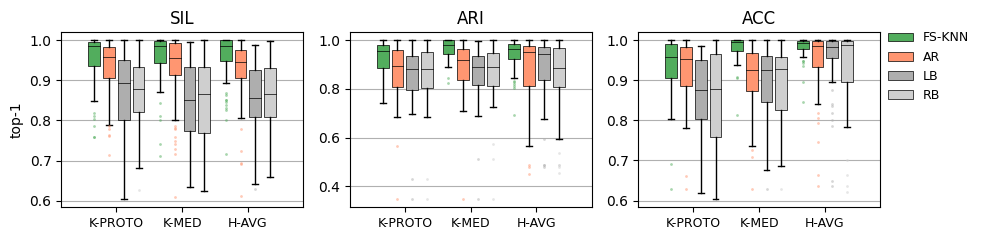

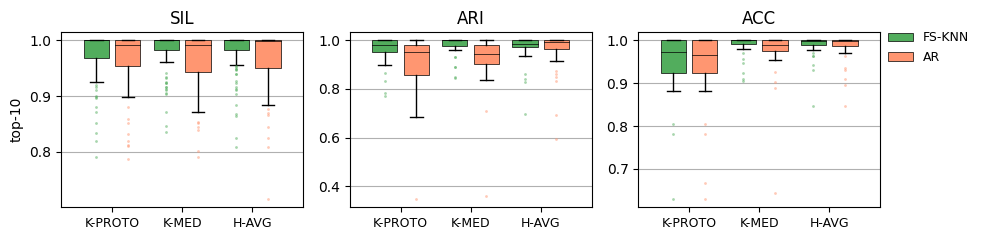

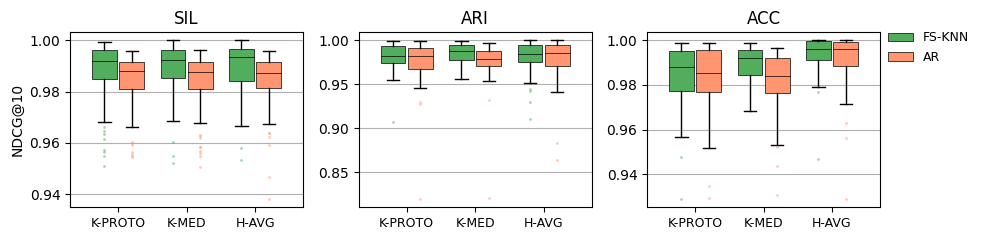

In [24]:
def show_scores(results, savedir=None):
    colors = {
        "AMF-FS-KNN": "#52AD5D",
        # "AMF-AE-KNN": "#FF9671",
        "AR": "#FF9671",
        # "AR": "#868686",
        "LB": "#AEAEAE",
        "RB": "#CFCFCF",
    }
    labels = {k: k for k in colors}
    labels["AMF-FS-KNN"] = "FS-KNN"
    # labels["AMF-AE-KNN"] = "AE-KNN"

    model_names = ["AMF-FS-KNN", "AR"] #, "MKNN", "MDTree", "PR-LR", "PR-KNN", "PR-DTree"

    fig = plt.figure(figsize=(9, 2.5))
    k = 1
    baselines = ["LB", "RB"]
    for j, eval_metric in enumerate(["sil", "ari", "acc"]):
        y = {}
        plt.subplot(1, 3, j+1)
        for algorithm in results:
            res = results[algorithm][eval_metric]["scores"]
            best_scores = res["Oracle"][1]
            for model_name in model_names:
                if model_name not in y:
                    y[model_name] = []
                l = res[model_name][k]
                if eval_metric in ["sil"]:
                    v = (l+1)/(best_scores+1)
                elif eval_metric in ["acc"]:
                    v = (l)/(best_scores)
                elif eval_metric in ["ari"]:
                    v = (l+0.5)/(best_scores+0.5)
                y[model_name].append(v)

            for name in baselines:
                if name not in y:
                    y[name] = []
                l = res[name][1]
                if eval_metric in ["sil"]:
                    v = (l+1)/(best_scores+1)
                elif eval_metric in ["acc"]:
                    v = (l)/(best_scores)
                elif eval_metric in ["ari"]:
                    v = (l+0.5)/(best_scores+0.5)
                y[name].append(v)

        n_bar = len(y)
        w = 0.9/n_bar
        x = np.arange(len(results))
        boxes = []
        i = 0
        for model_name, values in y.items():
            # min_ = min(min_, min(min(val) for val in values))          
            boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
            flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
                            linewidth=0)
            medianprops = dict(color='black', linewidth=0.5)
            meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
            b = plt.boxplot(values, positions=x+(i*w-(n_bar-1)*w/2), widths=0.8*w,  patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)
            boxes.append(b)
            i+=1
        if j==0: plt.ylabel(f"top-{k}")
        # plt.ylim((min_-0.02, 1.02))
        plt.xticks(x, [names[algo] for algo in results], rotation=0, fontsize=9)
        plt.grid(axis="y")
        plt.title(eval_metric.upper())
    plt.figlegend([box["boxes"][0] for box in boxes], labels.values(), fontsize=9, loc= "upper left", bbox_to_anchor= (0.98, 0.9), frameon=False)
    plt.tight_layout()
    if savedir is not None:
        plt.savefig(os.path.join(savedir, f"results_top{k}.pdf"), bbox_inches='tight')
    plt.show()
        
    fig = plt.figure(figsize=(9, 2.5))
    k = 10
    for j, eval_metric in enumerate(["sil", "ari", "acc"]):
        y = {}
        plt.subplot(1, 3, j+1)
        for algorithm in results:
            res = results[algorithm][eval_metric]["scores"]
            best_scores = res["Oracle"][1]
            for model_name in model_names:
                if model_name not in y:
                    y[model_name] = []
                l = res[model_name][k]
                if eval_metric in ["sil"]:
                    v = (l+1)/(best_scores+1)
                elif eval_metric in ["acc"]:
                    v = (l)/(best_scores)
                elif eval_metric in ["ari"]:
                    v = (l+0.5)/(best_scores+0.5)
                y[model_name].append(v)

        n_bar = len(y)
        w = 0.9/n_bar
        x = np.arange(len(results))
        boxes = []
        i = 0
        for model_name, values in y.items():            
            boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
            flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
                            linewidth=0)
            medianprops = dict(color='black', linewidth=0.5)
            meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
            b = plt.boxplot(values, positions=x+(i*w-(n_bar-1)*w/2), widths=0.8*w,  patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)
            boxes.append(b)
            i+=1
        if j==0: plt.ylabel(f"top-{k}")
        # plt.ylim((min_-0.02, 1.02))
        plt.xticks(x, [names[algo] for algo in results], rotation=0, fontsize=9)
        plt.grid(axis="y")
        plt.title(eval_metric.upper())
    plt.figlegend([box["boxes"][0] for box in boxes], labels.values(), fontsize=9, loc= "upper left", bbox_to_anchor= (0.98, 0.9), frameon=False)
    plt.tight_layout()
    if savedir is not None:
        plt.savefig(os.path.join(savedir, f"results_top{k}.pdf"), bbox_inches='tight')
    plt.show()
        
    fig = plt.figure(figsize=(9, 2.5))
    for j, eval_metric in enumerate(["sil", "ari", "acc"]):
        y = {}
        plt.subplot(1, 3, j+1)
        for algorithm in results:
            res = results[algorithm][eval_metric]["ndcg"]
            for model_name in model_names:
                if model_name not in y:
                    y[model_name] = []
                v = res[model_name][k]
                y[model_name].append(v)

        n_bar = len(y)
        w = 0.8/n_bar
        x = np.arange(len(results))
        boxes = []
        i = 0
        for model_name, values in y.items():            
            boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
            flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
                            linewidth=0)
            medianprops = dict(color='black', linewidth=0.5)
            meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
            b = plt.boxplot(values, positions=x+(i*w-(n_bar-1)*w/2), widths=0.9*w,  patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)
            boxes.append(b)
            i+=1
        if j==0: plt.ylabel(f"NDCG@{k}")
        plt.xticks(x, [names[algo] for algo in results], rotation=0, fontsize=9)
        plt.grid(axis="y")
        plt.title(eval_metric.upper())
        
        # if eval_metric=="sil":
        #     plt.figlegend([box["boxes"][0] for box in boxes], labels.values(), fontsize=10, loc= "lower center", bbox_to_anchor= (0.5, 1), frameon=False, ncol=len(model_names)+len(baselines))
    plt.figlegend([box["boxes"][0] for box in boxes], labels.values(), fontsize=9, loc= "upper left", bbox_to_anchor= (0.98, 0.9), frameon=False)
    plt.tight_layout()
    if savedir is not None:
        plt.savefig(os.path.join(savedir, f"results_ndcg{k}.pdf"), bbox_inches='tight')
    plt.show()

show_scores(results, savedir="imgs/") #

[34, 33, 33]
[32, 31, 32]
[34, 34, 34]


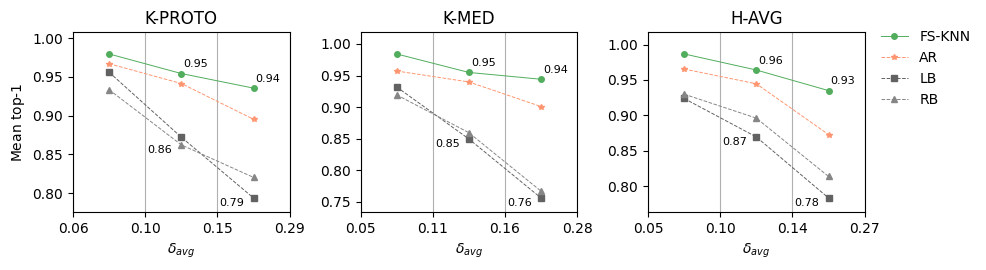

[14, 14, 14]
[12, 11, 12]
[17, 17, 17]


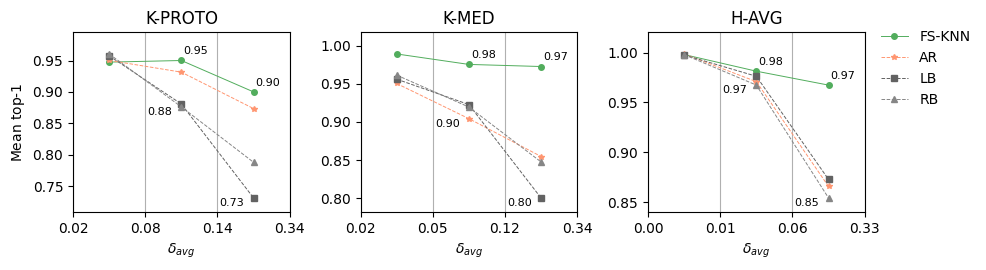

[14, 14, 14]
[12, 11, 12]
[17, 17, 17]


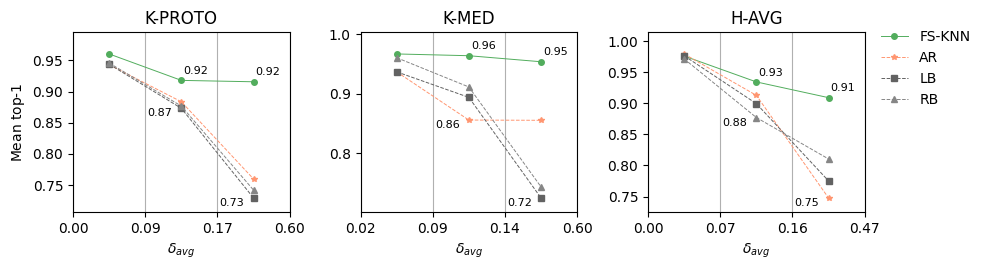

In [9]:
def show_results_delta(results, eval_metric="sil", savedir=None, list_algo=None):
    model_names = ["AMF-FS-KNN", "AR"]
    colors = {
        "AMF-FS-KNN": "#52AD5D",
        "AR": "#FF9671",
        "LB": "#626262",
        "RB": "#868686",
        # "AR": "#AFAFAF"
    }

    linestyle = {
        "AMF-FS-KNN": "-o",
        "AR": "--*",
        "LB": "--s",
        "RB": "--^"
    }
    labels = {k: k for k in colors}
    labels["AMF-FS-KNN"] = "FS-KNN"

    for eval_metric in ["sil", "acc", "ari"]:
        plt.figure(figsize=(3*3, 2.8))
        j = 1
        for algorithm in results:
            plt.subplot(1, 3, j)
            Y = train_res[algorithm][eval_metric]["Y"]
            if eval_metric in ["acc", "purity"]:
                Yn = np.array([y/max(y) for y in Y])
                # Yn[Yn > 0] **= 4
                Yn[Yn <= 0] = -1
            elif eval_metric == "ari":
                Yn = np.array([(y+0.5)/max(y+0.5) for y in Y])
                Yn[Yn <= 0] = -1
            else:
                Yn = np.array([(y+1)/max(y+1) for y in Y])
                Yn[Yn <= 0] = -1

            res = results[algorithm][eval_metric]["scores"]
            
            best_scores = res["Oracle"][1]
            lb_scores = res["LB"][1]
            l = [np.mean(1 - y[y>-1]) for i, y in enumerate(Yn)]
            x = np.array([np.quantile(l, q) for q in np.linspace(0, 1, 4)])
            
            x[0] -= 1e-4
            diff = 0.025
            list_indices = [
                [xr < np.mean(1 - y[y>-1]) <= x[r+1] for i, y in enumerate(Yn)]
                for r, xr in enumerate(x[:-1])
            ] #

            k=1
            baselines = ["LB", "RB"]
            y = {}
            yerr = {}
            print([sum(indices) for indices in list_indices])
            for model_name in model_names:
                y[model_name] = []
                yerr[model_name] = []
                scores = res[model_name][k]
                for i, indices in enumerate(list_indices):
                    if eval_metric in ["sil"]:
                        ln = ((scores+1)/(best_scores+1))[indices]
                    elif eval_metric in ["ari"]:
                        ln = ((scores+0.5)/(best_scores+0.5))[indices]
                    else:
                        ln = (scores/best_scores)[indices]
                    v = np.mean(ln)
                    std = np.std(ln)
                    y[model_name].append(v)
                    yerr[model_name].append(std)

            for name in baselines:
                y[name] = []
                yerr[name] = []
                scores = res[name][1]
                for i, indices in enumerate(list_indices):
                    if eval_metric in ["sil"]:
                        ln = ((scores+1)/(best_scores+1))[indices]
                    elif eval_metric in ["ari"]:
                        ln = ((scores+0.5)/(best_scores+0.5))[indices]
                    else:
                        ln = (scores/best_scores)[indices]
                    v = np.mean(ln)
                    std = np.std(ln)
                    y[name].append(v)
                    yerr[name].append(std)

            n_bar = len(y)
            w = 0.8/n_bar
            z = np.arange(len(x))
            i = 0
            max_ = np.zeros(len(list_indices))
            min_ = np.ones(len(list_indices))*100
            for model_name, values in y.items():
                max_ = np.maximum(max_, values)
                min_ = np.minimum(min_, values)
                plt.plot(z[:-1]+0.5, values, linestyle[model_name], linewidth=0.7, c=colors[model_name], label=labels[model_name] if j==1 else None, markersize=4, zorder=10)
                i += 1

            # delta_x = max(x) - min(x)
            delta_y = max(max_) - min(min_)
            for ind, val in enumerate(list_indices):
                if ind >= 1:
                    plt.annotate(f"{max_[ind]:.02f}", (z[ind]+0.7, max_[ind]+delta_y*0.1), fontsize=8, ha="center", va="top")
                    plt.annotate(f"{min_[ind]:.02f}", (z[ind]+0.2, min_[ind]), fontsize=8, ha="center", va="top")

            plt.xlim((z[0], z[-1]))
            plt.ylim((min(min_) - delta_y*0.1, max(max_) + delta_y*0.15))
            if j == 1: plt.ylabel(f"Mean top-${k}$")
            plt.xticks(z, [f"{max(0, val):.2f}" for val in x])
            plt.grid(axis="x")
            plt.xlabel("$\delta_{avg}$")
            plt.title(names[algorithm])

            j += 1

        # if eval_metric=="sil":
        #     plt.figlegend(loc= "lower center", bbox_to_anchor= (0.5, 1), frameon=False, ncol=len(model_names)+len(baselines), fontsize=10)
        plt.figlegend(fontsize=10, loc= "upper left", bbox_to_anchor= (0.97, 0.92), frameon=False)

        plt.tight_layout()
        # if savedir is not None:
        #     plt.savefig(os.path.join(savedir, f"results_delta_{eval_metric}.pdf"), bbox_inches='tight')
        plt.show()

show_results_delta(results, savedir="imgs")

[34, 33, 33]
[32, 31, 32]
[34, 34, 34]


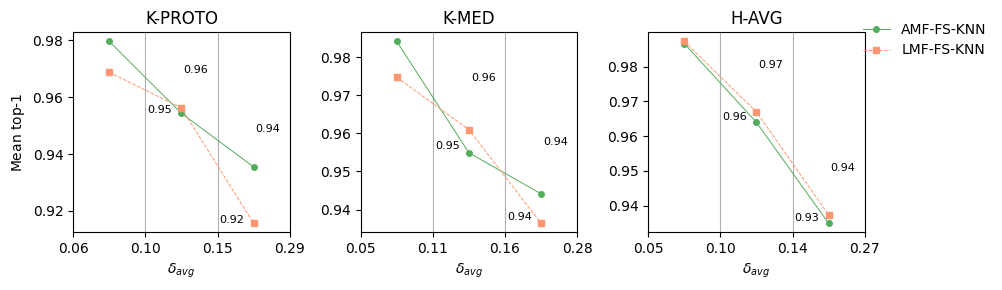

[14, 14, 14]
[12, 11, 12]
[17, 17, 17]


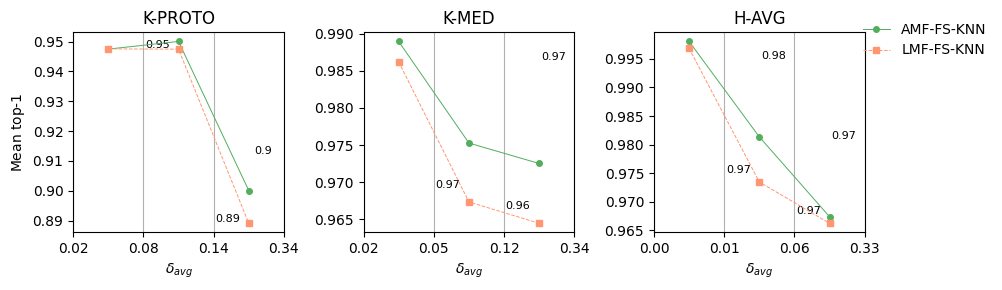

[14, 14, 14]
[12, 11, 12]
[17, 17, 17]


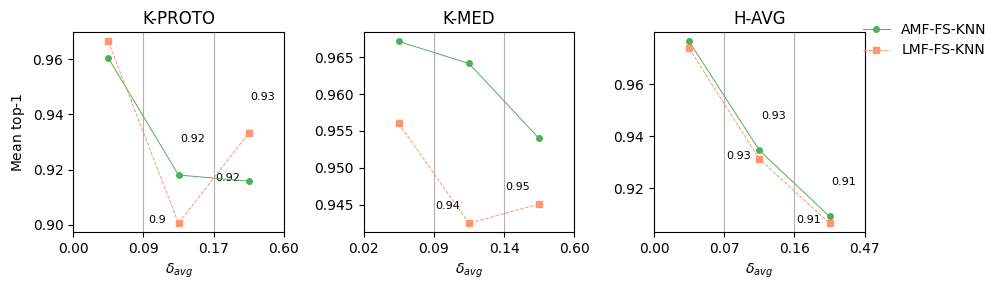

In [10]:
def show_results_delta(results, eval_metric="sil", savedir=None, list_algo=None):
    model_names = ["AMF-FS-KNN", "LMF-FS-KNN"]

    colors = {
        "AMF-FS-KNN": "#52AD5D",
        "LMF-FS-KNN": "#FF9671",
    }

    linestyle = {
        "AMF-FS-KNN": "-o",
        "LMF-FS-KNN": "--s",
    }
    for eval_metric in ["sil", "acc", "ari"]:
        plt.figure(figsize=(3*3, 3))
        j = 1
        for algorithm in results:
            plt.subplot(1, 3, j)
            Y = train_res[algorithm][eval_metric]["Y"]
            if eval_metric in ["acc", "purity"]:
                Yn = np.array([y/max(y) for y in Y])
                # Yn[Yn > 0] **= 4
                Yn[Yn <= 0] = -1
            elif eval_metric == "ari":
                Yn = np.array([(y+0.5)/max(y+0.5) for y in Y])
                Yn[Yn <= 0] = -1
            else:
                Yn = np.array([(y+1)/max(y+1) for y in Y])
                Yn[Yn <= 0] = -1

            res = results[algorithm][eval_metric]["scores"]
            
            best_scores = res["Oracle"][1]
            lb_scores = res["LB"][1]
            l = [np.mean(1 - y[y>-1]) for i, y in enumerate(Yn)]
            x = np.array([np.quantile(l, q) for q in np.linspace(0, 1, 4)])
            
            x[0] -= 1e-4
            diff = 0.025
            list_indices = [
                [xr < np.mean(1 - y[y>-1]) <= x[r+1] for i, y in enumerate(Yn)]
                for r, xr in enumerate(x[:-1])
            ] #

            k=1
            y = {}
            yerr = {}
            print([sum(indices) for indices in list_indices])
            for model_name in model_names:
                y[model_name] = []
                yerr[model_name] = []
                scores = res[model_name][k]
                for i, indices in enumerate(list_indices):
                    if eval_metric in ["sil"]:
                        ln = ((scores+1)/(best_scores+1))[indices]
                    elif eval_metric in ["ari"]:
                        ln = ((scores+0.5)/(best_scores+0.5))[indices]
                    else:
                        ln = (scores/best_scores)[indices]
                    v = np.mean(ln)
                    std = np.std(ln)
                    y[model_name].append(v)
                    yerr[model_name].append(std)

            n_bar = len(y)
            w = 0.8/n_bar
            z = np.arange(len(x))
            i = 0
            max_ = np.zeros(len(list_indices))
            min_ = np.ones(len(list_indices))*100
            for model_name, values in y.items():
                max_ = np.maximum(max_, values)
                min_ = np.minimum(min_, values)
                plt.plot(z[:-1]+0.5, values, linestyle[model_name], linewidth=0.7, c=colors[model_name], label=model_name if j==1 else None, markersize=4, zorder=10)
                i += 1

            for ind, val in enumerate(list_indices):
                if ind >= 1:
                    plt.annotate(f"{max_[ind]:.2g}", (z[ind]+0.7, max_[ind]+0.015), fontsize=8, ha="center", va="top")
                    plt.annotate(f"{min_[ind]:.2g}", (z[ind]+0.2, min_[ind]+0.003), fontsize=8, ha="center", va="top")

            plt.xlim((z[0], z[-1]))
            if j == 1: plt.ylabel(f"Mean top-${k}$")
            plt.xticks(z, [f"{max(0, val):.2f}" for val in x])
            plt.grid(axis="x")
            plt.xlabel("$\delta_{avg}$")
            plt.title(names[algorithm])

            j += 1

        plt.figlegend(fontsize=10, loc= "upper left", bbox_to_anchor= (0.95, 0.95), frameon=False)

        plt.tight_layout()
        if savedir is not None:
            plt.savefig(os.path.join(savedir, f"results_delta_{algo}.pdf"), bbox_inches='tight')
        plt.show()

show_results_delta(results)

In [11]:
eval_metric = 'sil'
l1 = set(train_res["kprototypes"][eval_metric]["selected_features"])
l2 = set(train_res["fasterpam"][eval_metric]["selected_features"])
l3 = set(train_res["haverage"][eval_metric]["selected_features"])
intersection = l1.intersection(l2).intersection(l3)
print(len(intersection), intersection)
print(len(l1.difference(intersection)), l1.difference(intersection))
print(len(l2.difference(intersection)), l2.difference(intersection))
print(len(l3.difference(intersection)), l3.difference(intersection))

9 {'q1_std_internal_product_num_att', 'max_entropy_cat_att', 'max_std_freq_cat_att', 'min_std_num_att', 'mean_std_internal_product_num_att', 'mean_card_cat_att', 'n_instances', 'dim', 'q3_means_internal_product_num_att'}
22 {'min_means_squared_num_att', 'min_card_cat_att', 'q1_means_squared_num_att', 'mean_means_squared_num_att', 'q3_std_num_att', 'q3_std_squared_num_att', 'max_means_internal_product_num_att', 'min_std_squared_num_att', 'max_mutual_info_cat_att', 'q1_means_num_att', 'max_means_squared_num_att', 'q1_card_cat_att', 'mean_covariance', 'q1_means_internal_product_num_att', 'q3_entropy_cat_att', 'min_std_internal_product_num_att', 'q1_covariance', 'max_std_num_att', 'q1_std_num_att', 'min_covariance', 'n_features', 'q1_mutual_info_cat_att'}
21 {'q3_std_internal_product_num_att', 'q1_means_squared_num_att', 'num_on_cat', 'mean_means_squared_num_att', 'q3_std_num_att', 'max_means_internal_product_num_att', 'min_std_freq_cat_att', 'min_mutual_info_cat_att', 'mean_means_internal

[23, 21, 16, 20, 20]
[23, 18, 16, 19, 19]
[23, 21, 17, 20, 21]


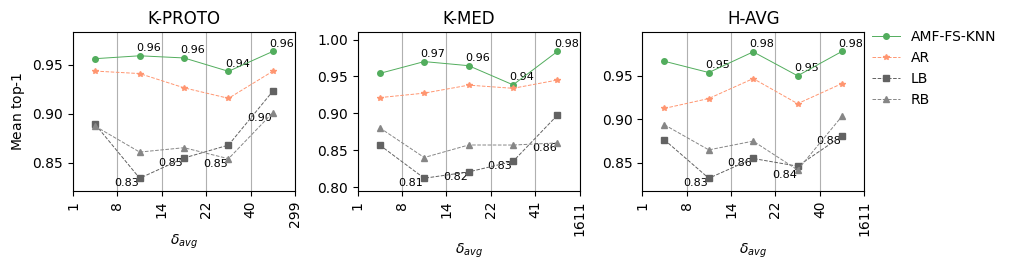

[9, 9, 7, 8, 9]
[8, 6, 7, 7, 7]
[11, 10, 10, 10, 10]


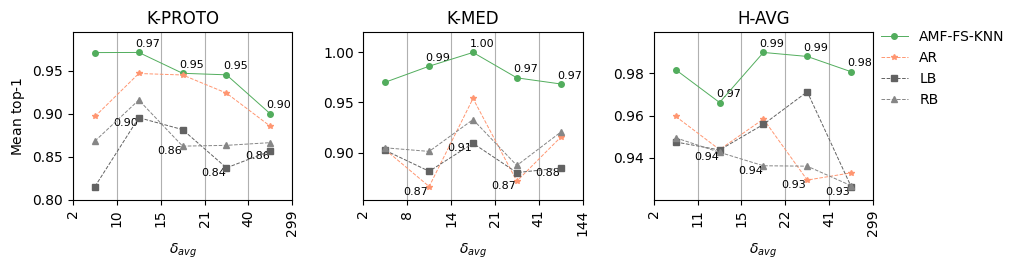

[9, 9, 7, 8, 9]
[8, 6, 7, 7, 7]
[11, 10, 10, 10, 10]


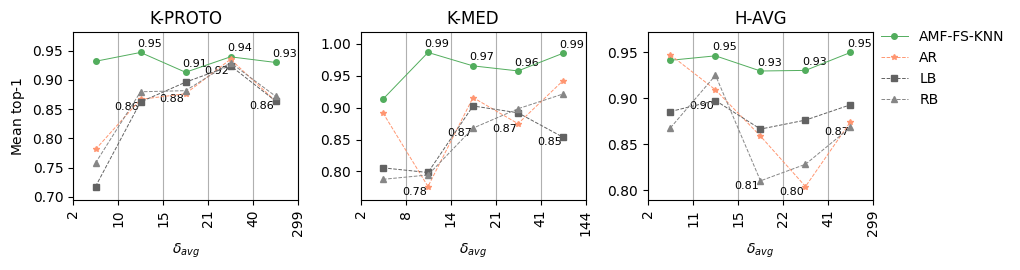

In [24]:
def show_results_delta(results, eval_metric="sil", savedir=None, list_algo=None):
    model_names = ["AMF-FS-KNN", "AR"]

    colors = {
        "AMF-FS-KNN": "#52AD5D",
        "AR": "#FF9671",
        "LB": "#626262",
        "RB": "#868686",
        # "ARB": "#AFAFAF"
    }

    linestyle = {
        "AMF-FS-KNN": "-o",
        "LB": "--s",
        "RB": "--^",
        "AR": "--*"
    }
    for eval_metric in ["sil", "acc", "ari"]:
        plt.figure(figsize=(3*3, 2.8))
        j = 1
        for algorithm in results:
            plt.subplot(1, 3, j)
            Y = train_res[algorithm][eval_metric]["Y"]
            n_features = train_res[algorithm][eval_metric]["meta_dataset"][0].n_features.to_numpy()
            if eval_metric in ["acc", "purity"]:
                Yn = np.array([y/max(y) for y in Y])
                # Yn[Yn > 0] **= 4
                Yn[Yn <= 0] = -1
            elif eval_metric == "ari":
                Yn = np.array([(y+0.5)/max(y+0.5) for y in Y])
                Yn[Yn <= 0] = -1
            else:
                Yn = np.array([(y+1)/max(y+1) for y in Y])
                Yn[Yn <= 0] = -1

            res = results[algorithm][eval_metric]["scores"]
            
            best_scores = res["Oracle"][1]
            lb_scores = res["LB"][1]
            l = n_features
            x = np.array([np.quantile(l, q) for q in np.linspace(0, 1, 6)])
            
            x[0] -= 1e-4
            diff = 0.025
            list_indices = [
                [xr < n <= x[r+1] for i, n in enumerate(n_features)]
                for r, xr in enumerate(x[:-1])
            ] #

            k=1
            baselines = ["LB", "RB"]
            y = {}
            yerr = {}
            print([sum(indices) for indices in list_indices])
            for model_name in model_names:
                y[model_name] = []
                yerr[model_name] = []
                scores = res[model_name][k]
                for i, indices in enumerate(list_indices):
                    if eval_metric in ["sil"]:
                        ln = ((scores+1)/(best_scores+1))[indices]
                    elif eval_metric in ["ari"]:
                        ln = ((scores+0.5)/(best_scores+0.5))[indices]
                    else:
                        ln = (scores/best_scores)[indices]
                    v = np.mean(ln)
                    std = np.std(ln)
                    y[model_name].append(v)
                    yerr[model_name].append(std)

            for name in baselines:
                y[name] = []
                yerr[name] = []
                scores = res[name][1]
                for i, indices in enumerate(list_indices):
                    if eval_metric in ["sil"]:
                        ln = ((scores+1)/(best_scores+1))[indices]
                    elif eval_metric in ["ari"]:
                        ln = ((scores+0.5)/(best_scores+0.5))[indices]
                    else:
                        ln = (scores/best_scores)[indices]
                    v = np.mean(ln)
                    std = np.std(ln)
                    y[name].append(v)
                    yerr[name].append(std)

            n_bar = len(y)
            w = 0.8/n_bar
            z = np.arange(len(x))
            i = 0
            max_ = np.zeros(len(list_indices))
            min_ = np.ones(len(list_indices))*100
            for model_name, values in y.items():
                max_ = np.maximum(max_, values)
                min_ = np.minimum(min_, values)
                plt.plot(z[:-1]+0.5, values, linestyle[model_name], linewidth=0.7, c=colors[model_name], label=model_name if j==1 else None, markersize=4, zorder=10)
                i += 1

            # delta_x = max(x) - min(x)
            delta_y = max(max_) - min(min_)
            for ind, val in enumerate(list_indices):
                if ind >= 1:
                    plt.annotate(f"{max_[ind]:.02f}", (z[ind]+0.7, max_[ind]+delta_y*0.1), fontsize=8, ha="center", va="top")
                    plt.annotate(f"{min_[ind]:.02f}", (z[ind]+0.2, min_[ind]), fontsize=8, ha="center", va="top")

            plt.xlim((z[0], z[-1]))
            plt.ylim((min(min_) - delta_y*0.1, max(max_) + delta_y*0.15))
            if j == 1: plt.ylabel(f"Mean top-${k}$")
            plt.xticks(z, [f"{max(0, int(val))}" for val in x], rotation="vertical")
            plt.grid(axis="x")
            plt.xlabel("$\delta_{avg}$")
            plt.title(names[algorithm])

            j += 1

        plt.figlegend(fontsize=10, loc= "upper left", bbox_to_anchor= (0.97, 0.92), frameon=False)

        plt.tight_layout()
        if savedir is not None:
            plt.savefig(os.path.join(savedir, f"results_delta_{algo}.pdf"), bbox_inches='tight')
        plt.show()

show_results_delta(results)